In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Dropout, Bidirectional
from tensorflow.keras.layers import Input, Concatenate, MultiHeadAttention
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import requests
from io import StringIO
import warnings
import os
import joblib

warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('ggplot')
sns.set_palette("viridis")
%matplotlib inline

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [12]:
# Load data
print("Fetching power consumption data...")
url = "https://hebbkx1anhila5yf.public.blob.vercel-storage.com/power_consumption_data-AsZjzrzoIsV2euGZGMMANnJFkKOwo8.csv"
response = requests.get(url)
data = pd.read_csv(StringIO(response.text))
print(f"Loaded {len(data)} records")

# Display the first few rows
data.head()

Fetching power consumption data...
Loaded 1441 records


,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,temp,humidity,conditions
0,2006-12-17,1.044,0.152,242.73,4.4,0.0,2.0,0.0,3.94,91.1,"Rain, Partially cloudy"
1,2006-12-18,0.278,0.126,246.17,1.2,0.0,2.0,0.0,4.39,87.5,"Rain, Partially cloudy"
2,2006-12-19,0.414,0.242,241.19,2.0,0.0,1.0,0.0,2.44,78.8,Partially cloudy
3,2006-12-20,0.824,0.058,245.57,3.4,0.0,0.0,0.0,2.72,72.3,Partially cloudy
4,2006-12-21,1.814,0.148,243.51,7.6,0.0,0.0,18.0,4.83,76.3,Partially cloudy


In [13]:
# Preprocess data
print("Preprocessing data...")

# Convert datetime to pandas datetime
data['datetime'] = pd.to_datetime(data['datetime'])

# Set datetime as index
data.set_index('datetime', inplace=True)

# Convert all numeric columns to float
numeric_cols = ['Global_active_power', 'Global_reactive_power', 'Voltage', 
               'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 
               'Sub_metering_3', 'temp', 'humidity']

for col in numeric_cols:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Check for missing values
missing_values = data.isnull().sum()
print("\nMissing values per column:")
print(missing_values)

# Fill missing values with forward fill (use previous value)
data.fillna(method='ffill', inplace=True)

# If any remaining missing values, fill with backward fill
data.fillna(method='bfill', inplace=True)

# Display the preprocessed data info
data.info()

Preprocessing data...

Missing values per column:
Global_active_power      15
Global_reactive_power    15
Voltage                  15
Global_intensity         15
Sub_metering_1           15
Sub_metering_2           15
Sub_metering_3           15
temp                      0
humidity                  0
conditions                0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1441 entries, 2006-12-17 to 2010-11-26
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Global_active_power    1441 non-null   float64
 1   Global_reactive_power  1441 non-null   float64
 2   Voltage                1441 non-null   float64
 3   Global_intensity       1441 non-null   float64
 4   Sub_metering_1         1441 non-null   float64
 5   Sub_metering_2         1441 non-null   float64
 6   Sub_metering_3         1441 non-null   float64
 7   temp                   1441 non-null   float64
 8   humidit

In [14]:
# First, let's identify which column contains the weather data
print("Columns in the dataset:")
print(data.columns.tolist())

# Let's look at the unique values in object columns to find the weather column
object_columns = data.select_dtypes(include=['object']).columns
for col in object_columns:
    unique_values = data[col].unique()
    print(f"\nUnique values in {col} ({len(unique_values)} unique values):")
    print(unique_values[:10])  # Show first 10 values to avoid overwhelming output

Columns in the dataset:
['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'temp', 'humidity', 'conditions']

Unique values in conditions (10 unique values):
['Rain, Partially cloudy' 'Partially cloudy' 'Clear' 'Overcast'
 'Rain, Overcast' 'Snow, Rain, Partially cloudy' 'Rain'
 'Snow, Rain, Overcast' 'Snow, Rain' 'Snow, Partially cloudy']


In [16]:
# Assuming the column is named 'weather_condition' (replace with actual name)
weather_condition = 'conditions'

# Method 1: One-hot encoding (best for correlation analysis)
print("\nApplying one-hot encoding to weather conditions...")
data_encoded = pd.get_dummies(data, columns=[weather_condition], prefix=['weather'])

# Now we can calculate correlations with the encoded weather data
correlation_matrix = data_encoded.select_dtypes(include=['number']).corr()

# Print top correlations with Global_active_power
target = 'Global_active_power'
correlations = correlation_matrix[target].sort_values(ascending=False)
print(f"\nTop correlations with {target}:")
print(correlations)

# Let's specifically look at correlations between weather conditions and power consumption
weather_correlations = correlations[correlations.index.str.startswith('weather_')]
print("\nCorrelations between weather conditions and power consumption:")
print(weather_correlations)


Applying one-hot encoding to weather conditions...

Top correlations with Global_active_power:
Global_active_power      1.000000
Global_intensity         0.998790
Sub_metering_3           0.641838
Sub_metering_1           0.410874
Sub_metering_2           0.342656
Global_reactive_power    0.142186
humidity                 0.042874
temp                    -0.119915
Voltage                 -0.305445
Name: Global_active_power, dtype: float64

Correlations between weather conditions and power consumption:
Series([], Name: Global_active_power, dtype: float64)


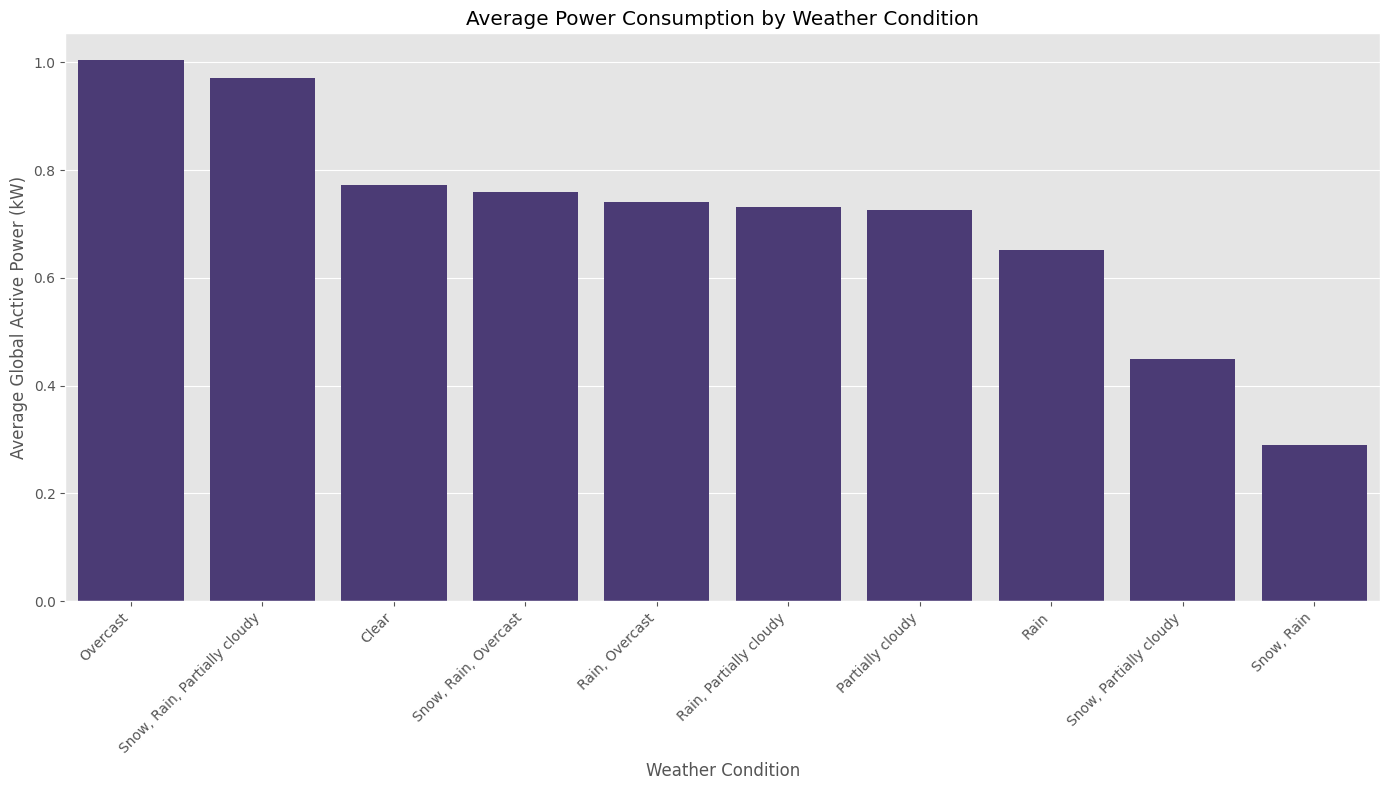

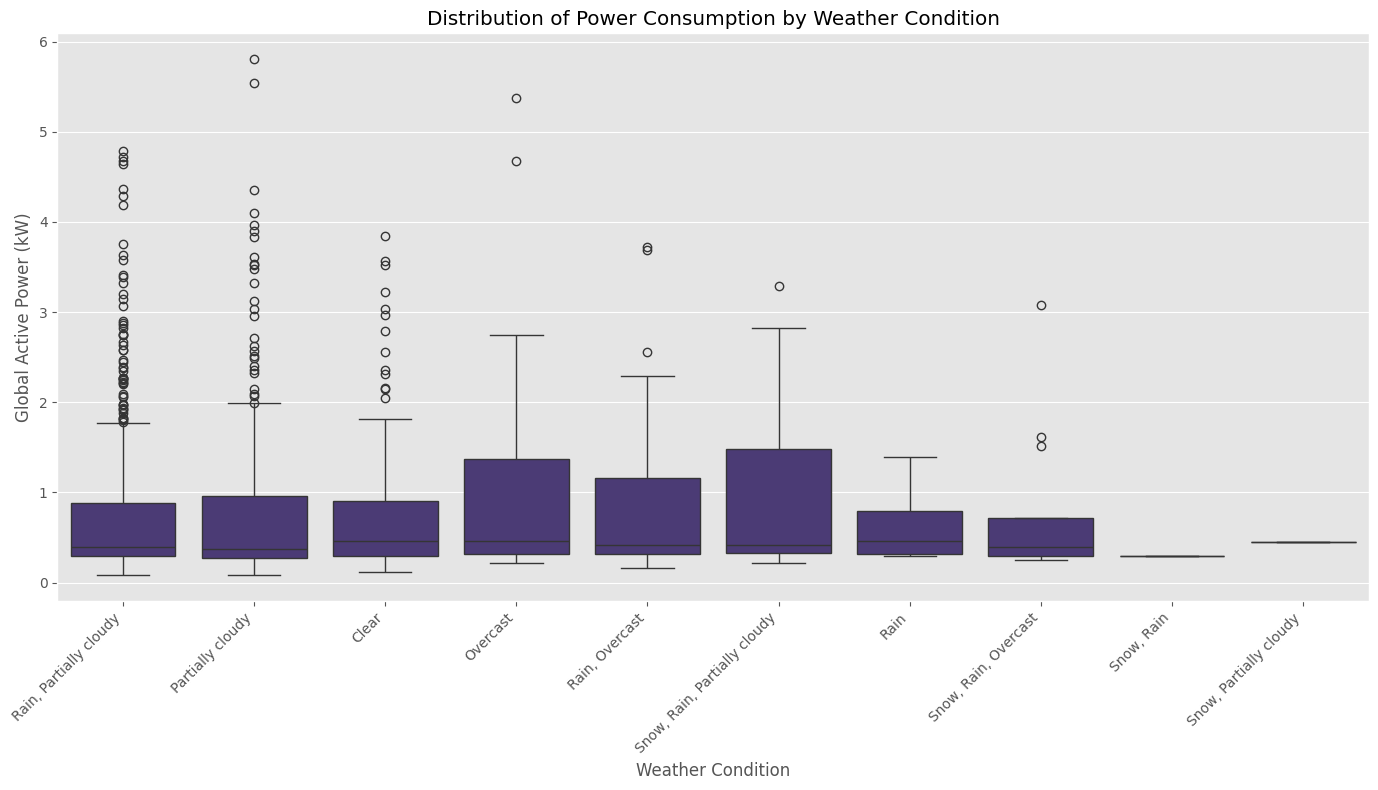

In [20]:
# Let's analyze how energy consumption varies by weather condition
plt.figure(figsize=(14, 8))

# Group by weather condition and calculate mean power consumption
weather_power = data.groupby(weather_condition)['Global_active_power'].mean().sort_values(ascending=False)

# Plot average power consumption by weather condition
sns.barplot(x=weather_power.index, y=weather_power.values)
plt.title('Average Power Consumption by Weather Condition')
plt.xlabel('Weather Condition')
plt.ylabel('Average Global Active Power (kW)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# We can also look at the distribution of power consumption for different weather conditions
plt.figure(figsize=(14, 8))
sns.boxplot(x=weather_condition, y='Global_active_power', data=data)
plt.title('Distribution of Power Consumption by Weather Condition')
plt.xlabel('Weather Condition')
plt.ylabel('Global Active Power (kW)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [21]:
# CELL: Include weather features in model preparation
# Make sure to include the encoded weather features in your feature selection
# If using one-hot encoding:
feature_cols = [col for col in data_encoded.columns 
                if col != 'Global_active_power' and 
                data_encoded[col].dtype in ['int64', 'float64']]

print(f"Total features including weather: {len(feature_cols)}")
print("Weather features included:", [col for col in feature_cols if 'weather_' in col])

# Continue with your modeling process using data_encoded instead of data

Total features including weather: 8
Weather features included: []


In [23]:
# Include encoded weather features in data frame
data_encoded = data_encoded.dropna()
print(f"Data shape after including weather features: {data_encoded.shape}")


Data shape after including weather features: (1441, 19)


In [25]:
# Basic statistics
print("\nBasic statistics:")
stats = data_encoded.describe().T
print(stats)

# Correlation analysis
print("\nCalculating correlations between variables...")
correlation_matrix = data_encoded.corr()

# Print top correlations with Global_active_power
target = 'Global_active_power'
correlations = correlation_matrix[target].sort_values(ascending=False)
print(f"\nTop correlations with {target}:")
print(correlations)


Basic statistics:
                        count        mean        std     min      25%  \
Global_active_power    1441.0    0.746419   0.791828    0.08    0.290   
Global_reactive_power  1441.0    0.116057   0.100379    0.00    0.048   
Voltage                1441.0  242.657189   2.789055  229.40  241.210   
Global_intensity       1441.0    3.156974   3.279419    0.20    1.200   
Sub_metering_1         1441.0    0.526718   4.227820    0.00    0.000   
Sub_metering_2         1441.0    0.700208   3.437587    0.00    0.000   
Sub_metering_3         1441.0    3.279667   6.472286    0.00    0.000   
temp                   1441.0   12.188494   6.437531   -4.72    7.560   
humidity               1441.0   72.586676  11.663047   35.10   64.600   

                           50%      75%      max  
Global_active_power      0.398    0.950    5.806  
Global_reactive_power    0.100    0.184    0.588  
Voltage                242.870  244.370  251.710  
Global_intensity         1.800    4.000   24.4

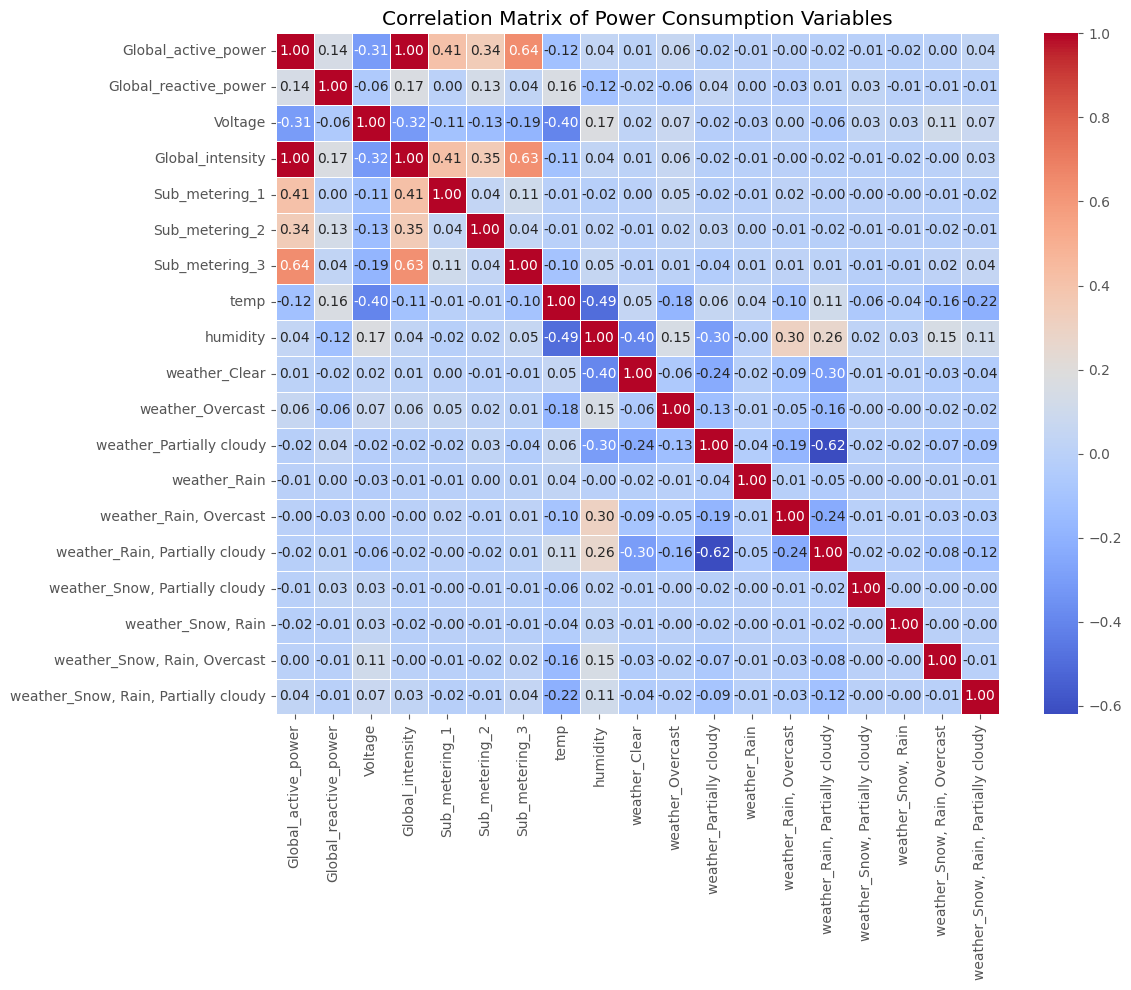

In [26]:
# Plot correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Power Consumption Variables')
plt.tight_layout()
plt.show()

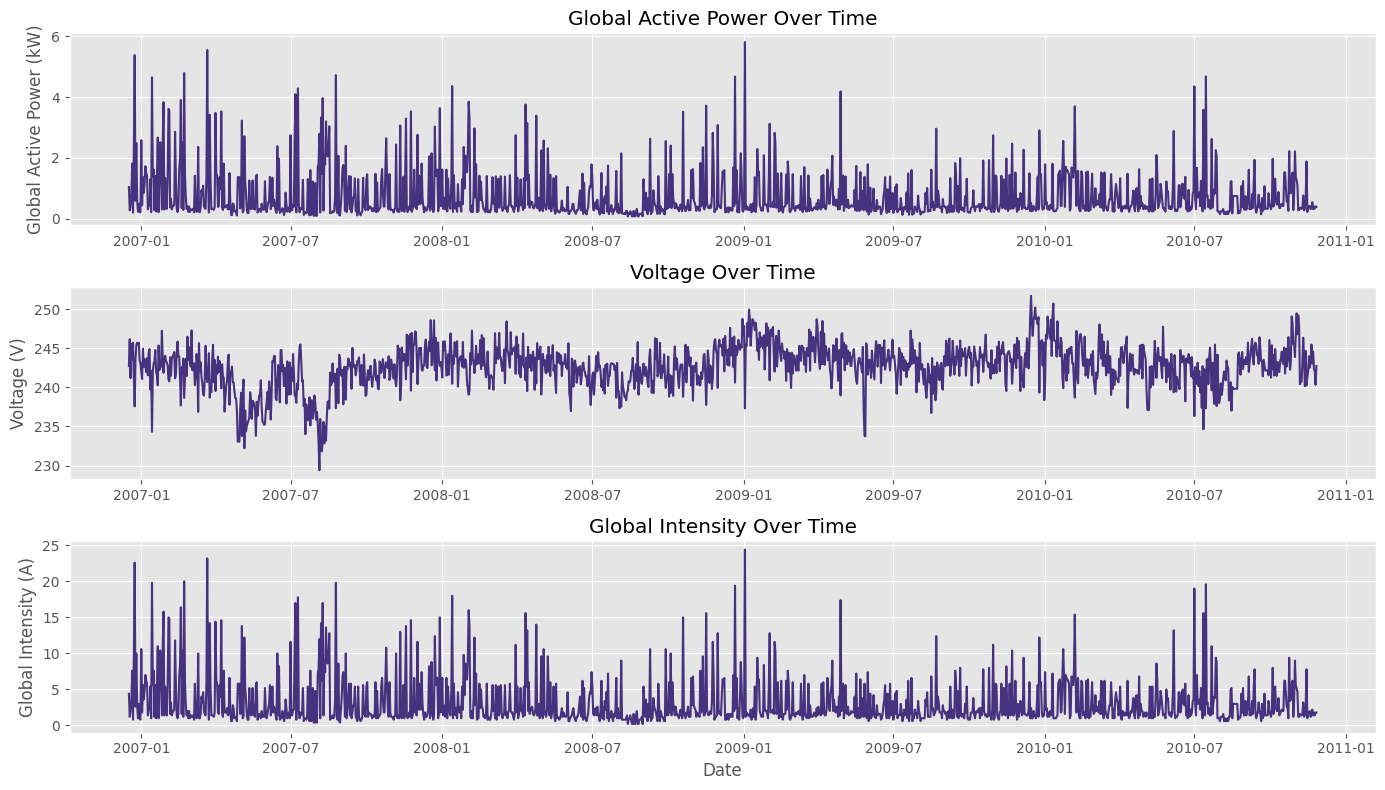

In [34]:
# Plot time series for main variables
plt.figure(figsize=(14, 8))
plt.subplot(3, 1, 1)
plt.plot(data_encoded.index, data_encoded['Global_active_power'])
plt.title('Global Active Power Over Time')
plt.ylabel('Global Active Power (kW)')

plt.subplot(3, 1, 2)
plt.plot(data_encoded.index, data_encoded['Voltage'])
plt.title('Voltage Over Time')
plt.ylabel('Voltage (V)')

plt.subplot(3, 1, 3)
plt.plot(data_encoded.index, data_encoded['Global_intensity'])
plt.title('Global Intensity Over Time')
plt.ylabel('Global Intensity (A)')
plt.xlabel('Date')

plt.tight_layout()
plt.show()

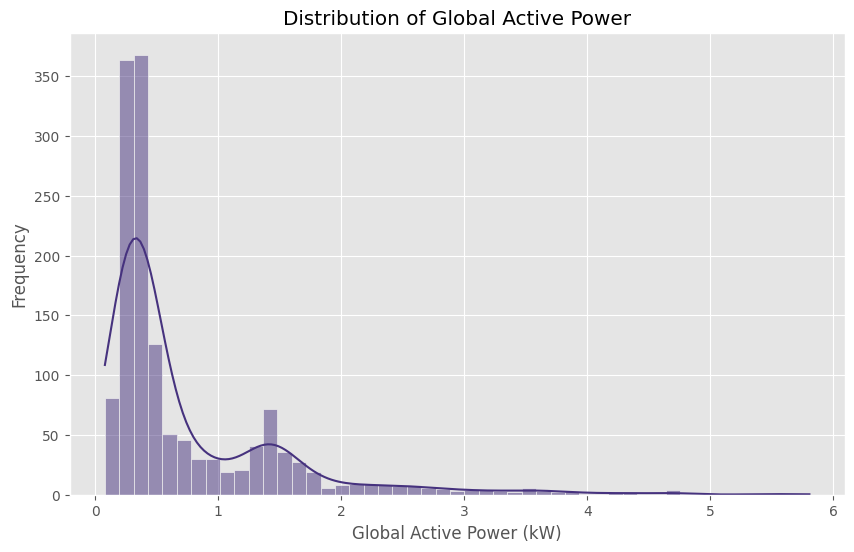

In [35]:
# Distribution of target variable
plt.figure(figsize=(10, 6))
sns.histplot(data['Global_active_power'], kde=True)
plt.title('Distribution of Global Active Power')
plt.xlabel('Global Active Power (kW)')
plt.ylabel('Frequency')
plt.show()

In [36]:
# Create a copy of the data
df = data_encoded.copy()

# 1. Time-based features
print("Creating time-based features...")
df['hour'] = df.index.hour
df['day'] = df.index.day
df['month'] = df.index.month
df['day_of_week'] = df.index.dayofweek
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Create cyclical features for hour, day of week, month
print("Creating cyclical features...")
df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)
df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week']/7)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week']/7)
df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
df['month_cos'] = np.cos(2 * np.pi * df['month']/12)

Creating time-based features...
Creating cyclical features...


In [37]:
# 2. Lag features
print("Creating lag features...")
target = 'Global_active_power'
for lag in [1, 2, 3, 6, 12, 24]:
    df[f'{target}_lag_{lag}'] = df[target].shift(lag)

# 3. Rolling window statistics
print("Creating rolling window features...")
for window in [6, 12, 24]:
    df[f'{target}_rolling_mean_{window}'] = df[target].rolling(window=window).mean()
    df[f'{target}_rolling_std_{window}'] = df[target].rolling(window=window).std()
    df[f'{target}_rolling_min_{window}'] = df[target].rolling(window=window).min()
    df[f'{target}_rolling_max_{window}'] = df[target].rolling(window=window).max()

Creating lag features...
Creating rolling window features...


In [38]:
# Feature engineering - difference and interaction features
# 4. Difference features
print("Creating difference features...")
df[f'{target}_diff_1'] = df[target].diff(1)
df[f'{target}_diff_24'] = df[target].diff(24)

# 5. Interaction features
print("Creating interaction features...")
df['power_intensity_ratio'] = df['Global_active_power'] / (df['Global_intensity'] + 1e-10)
df['power_voltage_ratio'] = df['Global_active_power'] / (df['Voltage'] + 1e-10)

Creating difference features...
Creating interaction features...


In [39]:
# Feature engineering - Fourier features and finalize
# 6. Fourier features for seasonality (if enough data)
if len(df) > 24*7:
    print("Creating Fourier features...")
    # Daily seasonality
    for k in range(1, 4):
        df[f'daily_sin_{k}'] = np.sin(2 * np.pi * k * df.index.hour / 24)
        df[f'daily_cos_{k}'] = np.cos(2 * np.pi * k * df.index.hour / 24)
    
    # Weekly seasonality
    for k in range(1, 3):
        df[f'weekly_sin_{k}'] = np.sin(2 * np.pi * k * df.index.dayofweek / 7)
        df[f'weekly_cos_{k}'] = np.cos(2 * np.pi * k * df.index.dayofweek / 7)

# Drop NaN values created by lag and rolling features
df.dropna(inplace=True)

# Show the new features
print(f"\nCreated {len(df.columns) - len(data.columns)} new features")
print("New feature list:", [col for col in df.columns if col not in data.columns])

# Display the engineered data
df.head()

Creating Fourier features...

Created 52 new features
New feature list: ['weather_Clear', 'weather_Overcast', 'weather_Partially cloudy', 'weather_Rain', 'weather_Rain, Overcast', 'weather_Rain, Partially cloudy', 'weather_Snow, Partially cloudy', 'weather_Snow, Rain', 'weather_Snow, Rain, Overcast', 'weather_Snow, Rain, Partially cloudy', 'hour', 'day', 'month', 'day_of_week', 'is_weekend', 'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'Global_active_power_lag_1', 'Global_active_power_lag_2', 'Global_active_power_lag_3', 'Global_active_power_lag_6', 'Global_active_power_lag_12', 'Global_active_power_lag_24', 'Global_active_power_rolling_mean_6', 'Global_active_power_rolling_std_6', 'Global_active_power_rolling_min_6', 'Global_active_power_rolling_max_6', 'Global_active_power_rolling_mean_12', 'Global_active_power_rolling_std_12', 'Global_active_power_rolling_min_12', 'Global_active_power_rolling_max_12', 'Global_active_power_rolling_mean_24', 

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,temp,humidity,weather_Clear,...,daily_sin_1,daily_cos_1,daily_sin_2,daily_cos_2,daily_sin_3,daily_cos_3,weekly_sin_1,weekly_cos_1,weekly_sin_2,weekly_cos_2
datetime,,,,,,,,,,,,,,,,,,,,,
2007-01-10,0.404,0.302,244.48,2.0,0.0,2.0,0.0,10.50,78.7,False,...,0.0,1.0,0.0,1.0,0.0,1.0,0.974928,-0.222521,-0.433884,-0.900969
2007-01-11,0.444,0.324,244.90,2.2,0.0,0.0,0.0,8.17,80.5,False,...,0.0,1.0,0.0,1.0,0.0,1.0,0.433884,-0.900969,-0.781831,0.623490
2007-01-12,1.296,0.138,239.74,5.4,0.0,1.0,0.0,10.39,79.4,False,...,0.0,1.0,0.0,1.0,0.0,1.0,-0.433884,-0.900969,0.781831,0.623490
2007-01-13,0.220,0.000,242.11,1.0,0.0,0.0,0.0,11.28,85.1,False,...,0.0,1.0,0.0,1.0,0.0,1.0,-0.974928,-0.222521,0.433884,-0.900969
2007-01-14,4.646,0.062,234.31,19.8,0.0,0.0,17.0,8.61,77.5,False,...,0.0,1.0,0.0,1.0,0.0,1.0,-0.781831,0.623490,-0.974928,-0.222521


In [40]:
# Feature importance analysis
# Set target variable
target_variable = 'Global_active_power'

# Prepare data for feature importance
X = df.drop(target_variable, axis=1)
y = df[target_variable]

# Train a simple Random Forest to get feature importance
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Get feature importance
importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 15 most important features:")
print(importance.head(15))


Top 15 most important features:
                                Feature  Importance
50                  power_voltage_ratio    0.908423
2                      Global_intensity    0.082606
48          Global_active_power_diff_24    0.002257
36    Global_active_power_rolling_std_6    0.002037
38    Global_active_power_rolling_max_6    0.001943
42   Global_active_power_rolling_max_12    0.000483
47           Global_active_power_diff_1    0.000474
46   Global_active_power_rolling_max_24    0.000321
6                                  temp    0.000315
30            Global_active_power_lag_2    0.000092
33           Global_active_power_lag_12    0.000090
7                              humidity    0.000086
32            Global_active_power_lag_6    0.000068
34           Global_active_power_lag_24    0.000058
43  Global_active_power_rolling_mean_24    0.000056


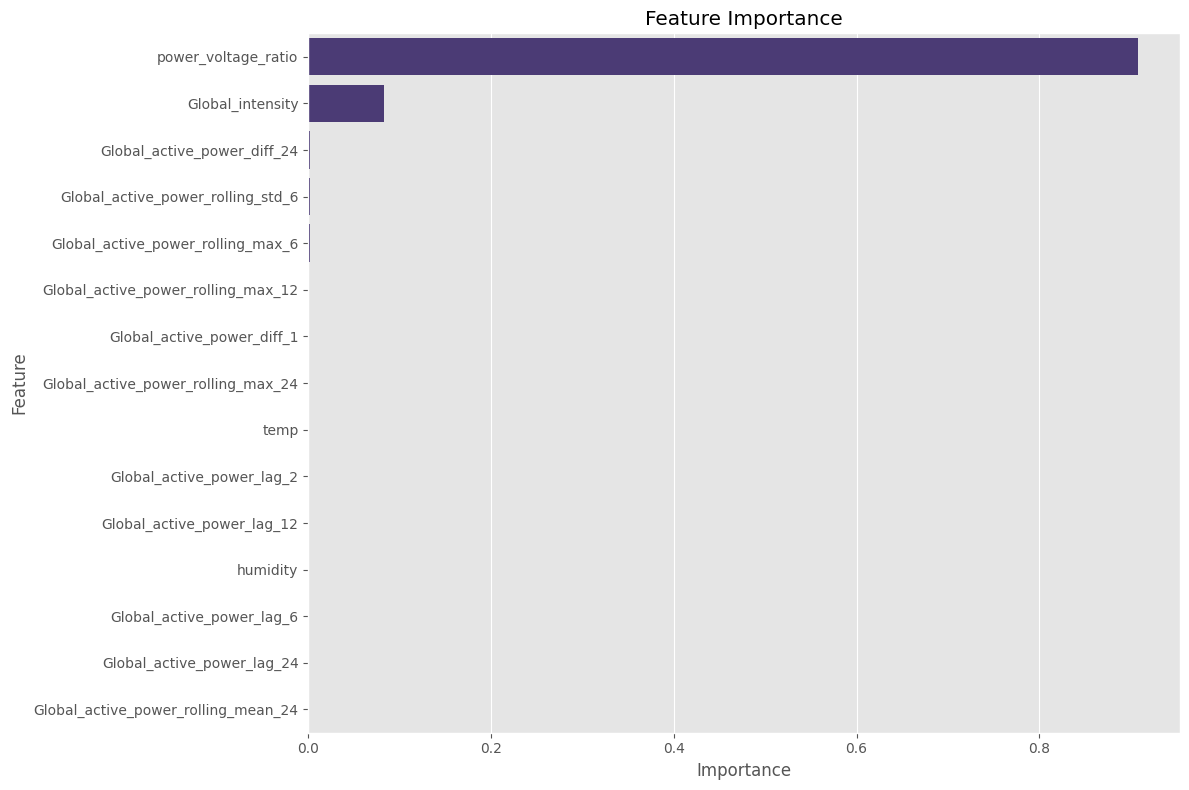

In [41]:
#Plot feature importance
# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance.head(15))
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

In [42]:
# Prepare time series data
# Select top features based on importance
top_features = importance.head(20)['Feature'].tolist()
feature_cols = [feat for feat in top_features if feat != target_variable]
print(f"Selected {len(feature_cols)} features for modeling")

# Prepare time series data
lookback = 24  # Use 24 time steps of history
print(f"\nPreparing time series data with lookback of {lookback}...")

# Extract features and target
features = df[feature_cols].values
target = df[target_variable].values

X, y = [], []
for i in range(len(target) - lookback):
    X.append(features[i:i+lookback])
    y.append(target[i+lookback])

X = np.array(X)
y = np.array(y).reshape(-1, 1)

print(f"Created {len(X)} sequences with shape {X.shape}")

Selected 20 features for modeling

Preparing time series data with lookback of 24...
Created 1393 sequences with shape (1393, 24, 20)


In [44]:
# Split and scale data
# Split data into training, validation, and testing sets
# First split into train+val and test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Then split train+val into train and val
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, shuffle=False)

print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")

# Scale the data
print("\nScaling data...")

# Reshape data for scaling
n_samples_train, n_timesteps, n_features = X_train.shape
n_samples_test = X_test.shape[0]
n_samples_val = X_val.shape[0]

# Scale features
feature_scaler = MinMaxScaler()
X_train_reshaped = X_train.reshape(n_samples_train * n_timesteps, n_features)
X_train_scaled = feature_scaler.fit_transform(X_train_reshaped)
X_train_scaled = X_train_scaled.reshape(n_samples_train, n_timesteps, n_features)

X_test_reshaped = X_test.reshape(n_samples_test * n_timesteps, n_features)
X_test_scaled = feature_scaler.transform(X_test_reshaped)
X_test_scaled = X_test_scaled.reshape(n_samples_test, n_timesteps, n_features)

X_val_reshaped = X_val.reshape(n_samples_val * n_timesteps, n_features)
X_val_scaled = feature_scaler.transform(X_val_reshaped)
X_val_scaled = X_val_scaled.reshape(n_samples_val, n_timesteps, n_features)

# Scale target
target_scaler = MinMaxScaler()
y_train_scaled = target_scaler.fit_transform(y_train)
y_test_scaled = target_scaler.transform(y_test)
y_val_scaled = target_scaler.transform(y_val)

Training set: (891, 24, 20), Validation set: (223, 24, 20), Test set: (279, 24, 20)

Scaling data...


In [45]:
# Build and train LSTM model
# Build and train LSTM model
print("\nBuilding and training LSTM model...")

n_timesteps, n_features = X_train_scaled.shape[1], X_train_scaled.shape[2]

# Build model
lstm_model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(n_timesteps, n_features)),
    Dropout(0.2),
    LSTM(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(y_train_scaled.shape[1])
])

# Compile model
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)

# Train model
lstm_history = lstm_model.fit(
    X_train_scaled, y_train_scaled,
    epochs=20,  # Reduced for faster execution
    batch_size=32,
    validation_data=(X_val_scaled, y_val_scaled),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Building and training LSTM model...
Epoch 1/20
28/28 [==============================] - 2s 24ms/step - loss: 0.0264 - mae: 0.1089 - val_loss: 0.0126 - val_mae: 0.0821 - lr: 0.0010
Epoch 2/20
28/28 [==============================] - 0s 16ms/step - loss: 0.0220 - mae: 0.1046 - val_loss: 0.0123 - val_mae: 0.0920 - lr: 0.0010
Epoch 3/20
28/28 [==============================] - 0s 15ms/step - loss: 0.0217 - mae: 0.1045 - val_loss: 0.0119 - val_mae: 0.0839 - lr: 0.0010
Epoch 4/20
28/28 [==============================] - 0s 16ms/step - loss: 0.0217 - mae: 0.1058 - val_loss: 0.0120 - val_mae: 0.0888 - lr: 0.0010
Epoch 5/20
28/28 [==============================] - 0s 16ms/step - loss: 0.0217 - mae: 0.1046 - val_loss: 0.0122 - val_mae: 0.0778 - lr: 0.0010
Epoch 6/20
28/28 [==============================] - 0s 15ms/step - loss: 0.0218 - mae: 0.1025 - val_loss: 0.0118 - val_mae: 0.0819 - lr: 0.0010
Epoch 7/20
28/28 [==============================] - 1s 19ms/step - loss: 0.0213 - mae: 0.1044 - val

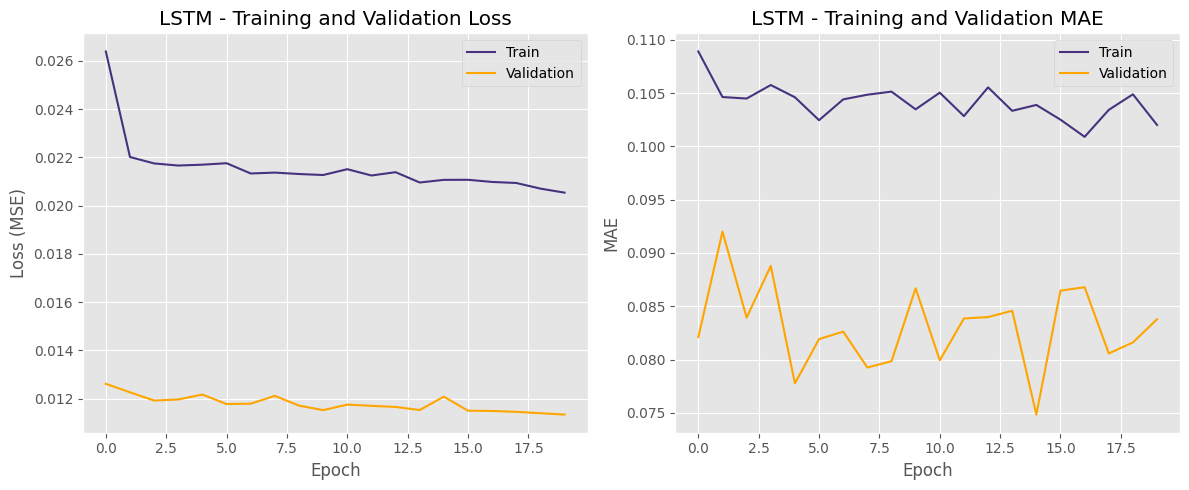

In [48]:
# Plot LSTM training history
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'],color='orange')
plt.title('LSTM - Training and Validation Loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(lstm_history.history['mae'])
plt.plot(lstm_history.history['val_mae'],color='orange')
plt.title('LSTM - Training and Validation MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()
plt.show()

In [49]:
# Build and train GRU model
# Build and train GRU model
print("\nBuilding and training GRU model...")

# Build model
gru_model = Sequential([
    GRU(64, activation='relu', return_sequences=True, input_shape=(n_timesteps, n_features)),
    Dropout(0.2),
    GRU(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(y_train_scaled.shape[1])
])

# Compile model
gru_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Train model
gru_history = gru_model.fit(
    X_train_scaled, y_train_scaled,
    epochs=20,  # Reduced for faster execution
    batch_size=32,
    validation_data=(X_val_scaled, y_val_scaled),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Building and training GRU model...
Epoch 1/20
28/28 [==============================] - 2s 23ms/step - loss: 0.0311 - mae: 0.1225 - val_loss: 0.0128 - val_mae: 0.0753 - lr: 0.0010
Epoch 2/20
28/28 [==============================] - 0s 14ms/step - loss: 0.0218 - mae: 0.1003 - val_loss: 0.0122 - val_mae: 0.0925 - lr: 0.0010
Epoch 3/20
28/28 [==============================] - 0s 14ms/step - loss: 0.0216 - mae: 0.1038 - val_loss: 0.0118 - val_mae: 0.0844 - lr: 0.0010
Epoch 4/20
28/28 [==============================] - 0s 14ms/step - loss: 0.0216 - mae: 0.1055 - val_loss: 0.0117 - val_mae: 0.0858 - lr: 0.0010
Epoch 5/20
28/28 [==============================] - 0s 16ms/step - loss: 0.0212 - mae: 0.1045 - val_loss: 0.0119 - val_mae: 0.0792 - lr: 0.0010
Epoch 6/20
28/28 [==============================] - 0s 15ms/step - loss: 0.0213 - mae: 0.1019 - val_loss: 0.0118 - val_mae: 0.0831 - lr: 0.0010
Epoch 7/20
28/28 [==============================] - 0s 16ms/step - loss: 0.0212 - mae: 0.1038 - val_

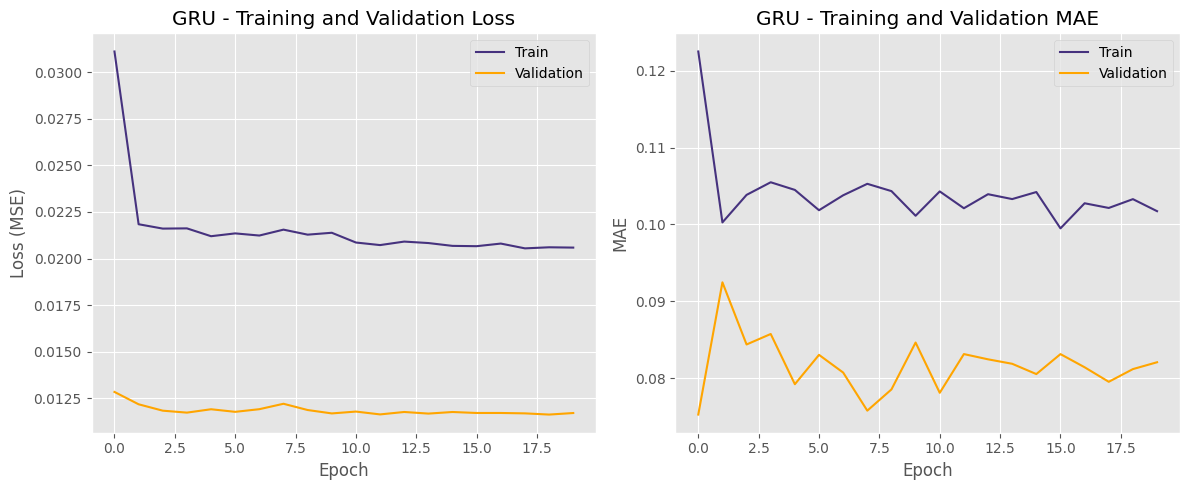

In [52]:
# Plot GRU training history
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(gru_history.history['loss'])
plt.plot(gru_history.history['val_loss'], color='orange')
plt.title('GRU - Training and Validation Loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(gru_history.history['mae'])
plt.plot(gru_history.history['val_mae'],color='orange')
plt.title('GRU - Training and Validation MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()
plt.show()

In [53]:
# Define evaluation function
def evaluate_model(model, X_test, y_test, target_scaler, model_name):
    """Function to evaluate model."""
    print(f"\nEvaluating {model_name} model...")
    
    # Make predictions
    y_pred_scaled = model.predict(X_test)
    
    # Inverse transform predictions and actual values
    y_pred = target_scaler.inverse_transform(y_pred_scaled)
    y_true = target_scaler.inverse_transform(y_test)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Calculate MAPE
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-10))) * 100
    
    print(f"{model_name} - RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%, R²: {r2:.4f}")
    
    # Plot predictions vs actual
    plt.figure(figsize=(14, 7))
    plt.plot(y_true[:100], label='Actual')
    plt.plot(y_pred[:100], label=f'Predicted ({model_name})')
    plt.title(f'Actual vs Predicted Values - {model_name} Model')
    plt.xlabel('Time Steps')
    plt.ylabel('Global Active Power')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Plot prediction error distribution
    errors = y_true.flatten() - y_pred.flatten()
    plt.figure(figsize=(10, 6))
    sns.histplot(errors, kde=True)
    plt.title(f'Prediction Error Distribution - {model_name} Model')
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')
    plt.axvline(x=0, color='r', linestyle='--')
    plt.tight_layout()
    plt.show()
    
    return {
        'name': model_name,
        'model': model,
        'rmse': rmse,
        'mae': mae,
        'mape': mape,
        'r2': r2,
        'predictions': y_pred
    }


Evaluating LSTM model...
9/9 [==============================] - 0s 5ms/step
LSTM - RMSE: 0.6106, MAE: 0.4202, MAPE: 85.66%, R²: -0.0200


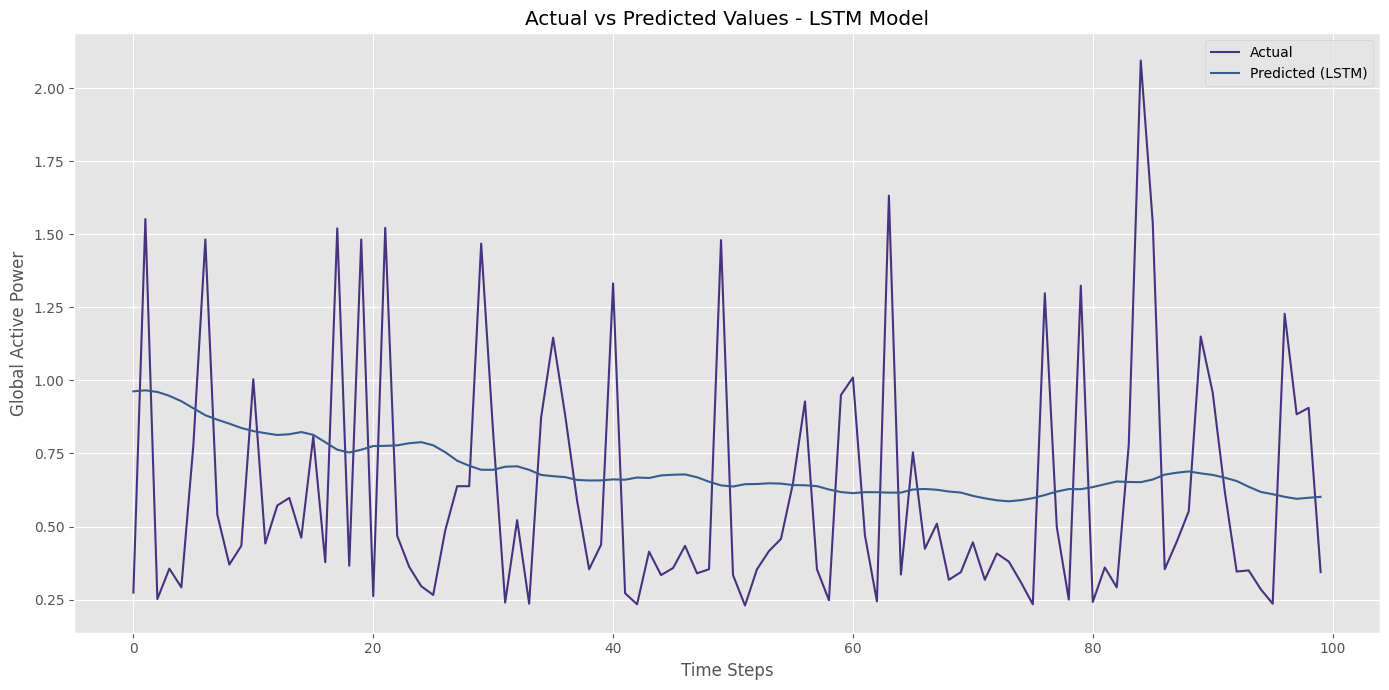

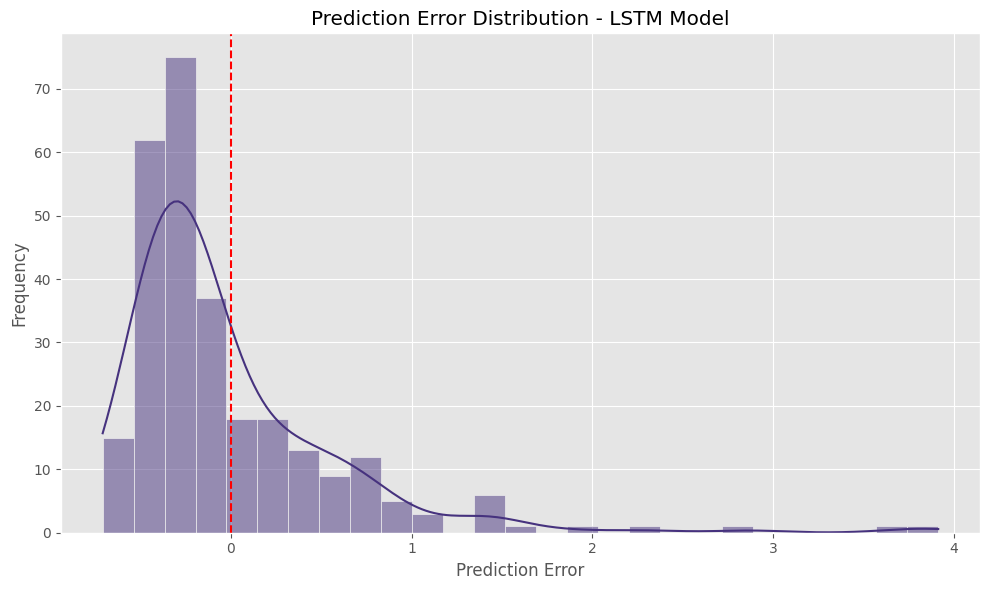


Evaluating GRU model...
9/9 [==============================] - 0s 9ms/step
GRU - RMSE: 0.6059, MAE: 0.4057, MAPE: 77.13%, R²: -0.0040


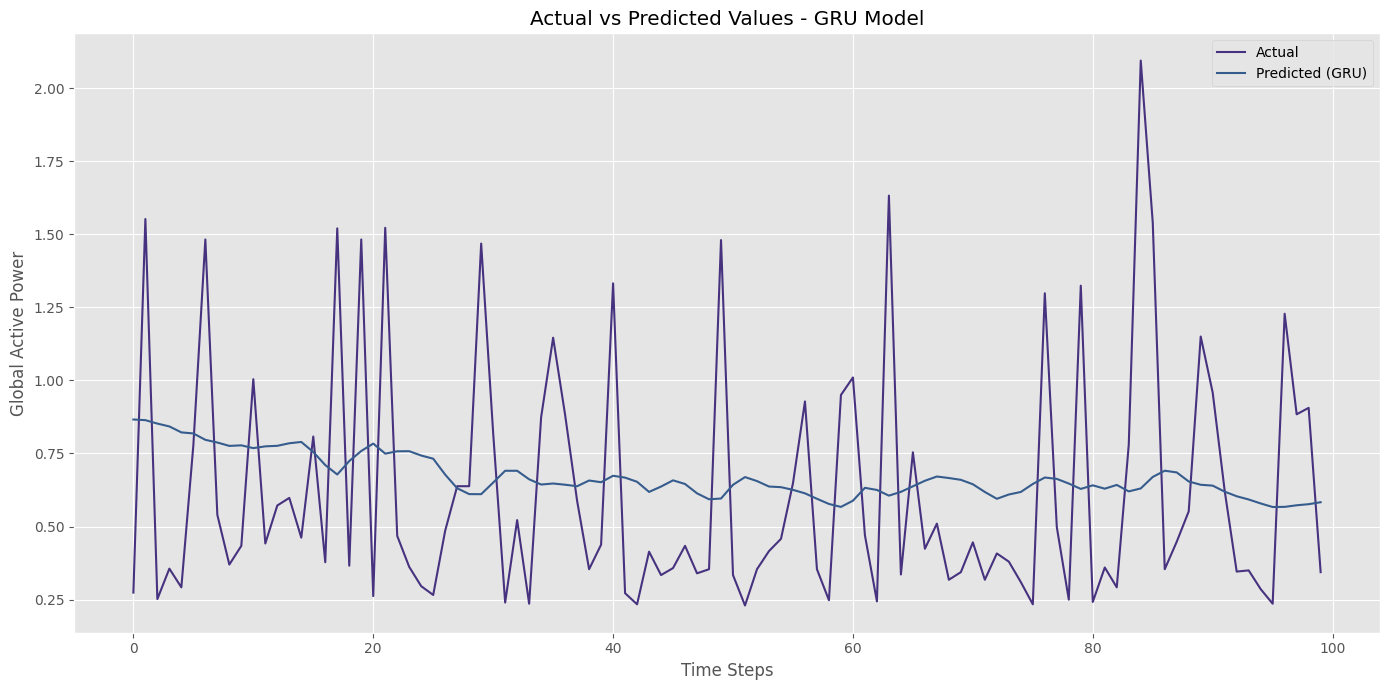

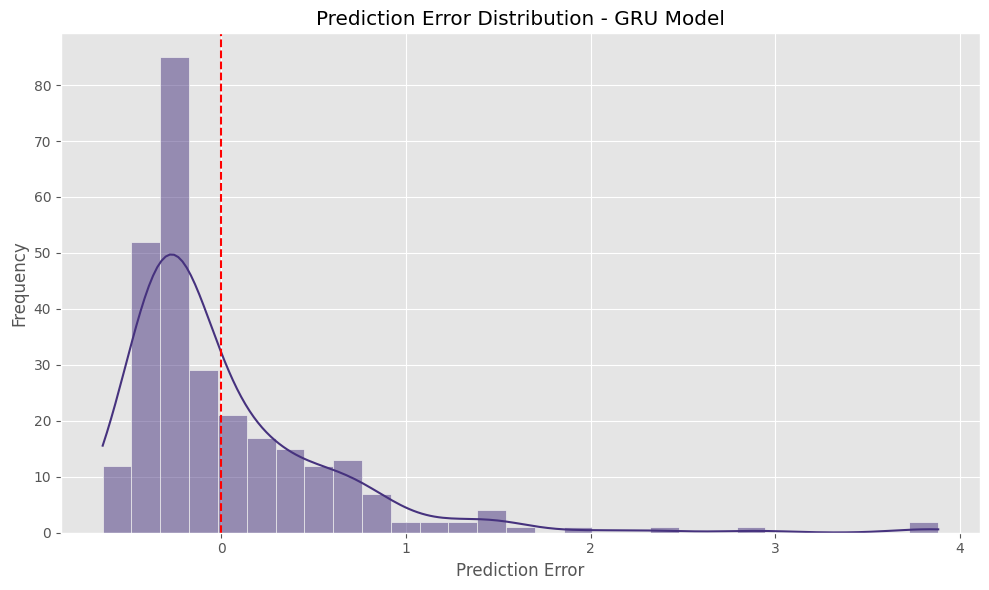

In [54]:
# Evaluate models
# Evaluate models
models_results = []

# Evaluate LSTM
lstm_results = evaluate_model(lstm_model, X_test_scaled, y_test_scaled, target_scaler, 'LSTM')
models_results.append(lstm_results)

# Evaluate GRU
gru_results = evaluate_model(gru_model, X_test_scaled, y_test_scaled, target_scaler, 'GRU')
models_results.append(gru_results)

In [55]:
# Compare models
# Create comparison dataframe
comparison = pd.DataFrame({
    'Model': [model['name'] for model in models_results],
    'RMSE': [model['rmse'] for model in models_results],
    'MAE': [model['mae'] for model in models_results],
    'MAPE (%)': [model['mape'] for model in models_results],
    'R²': [model['r2'] for model in models_results]
})

# Sort by RMSE
comparison = comparison.sort_values('RMSE')
print("\nModel Performance Comparison:")
print(comparison)


Model Performance Comparison:
  Model      RMSE       MAE   MAPE (%)        R²
1   GRU  0.605856  0.405746  77.133274 -0.004046
0  LSTM  0.610642  0.420228  85.661951 -0.019972


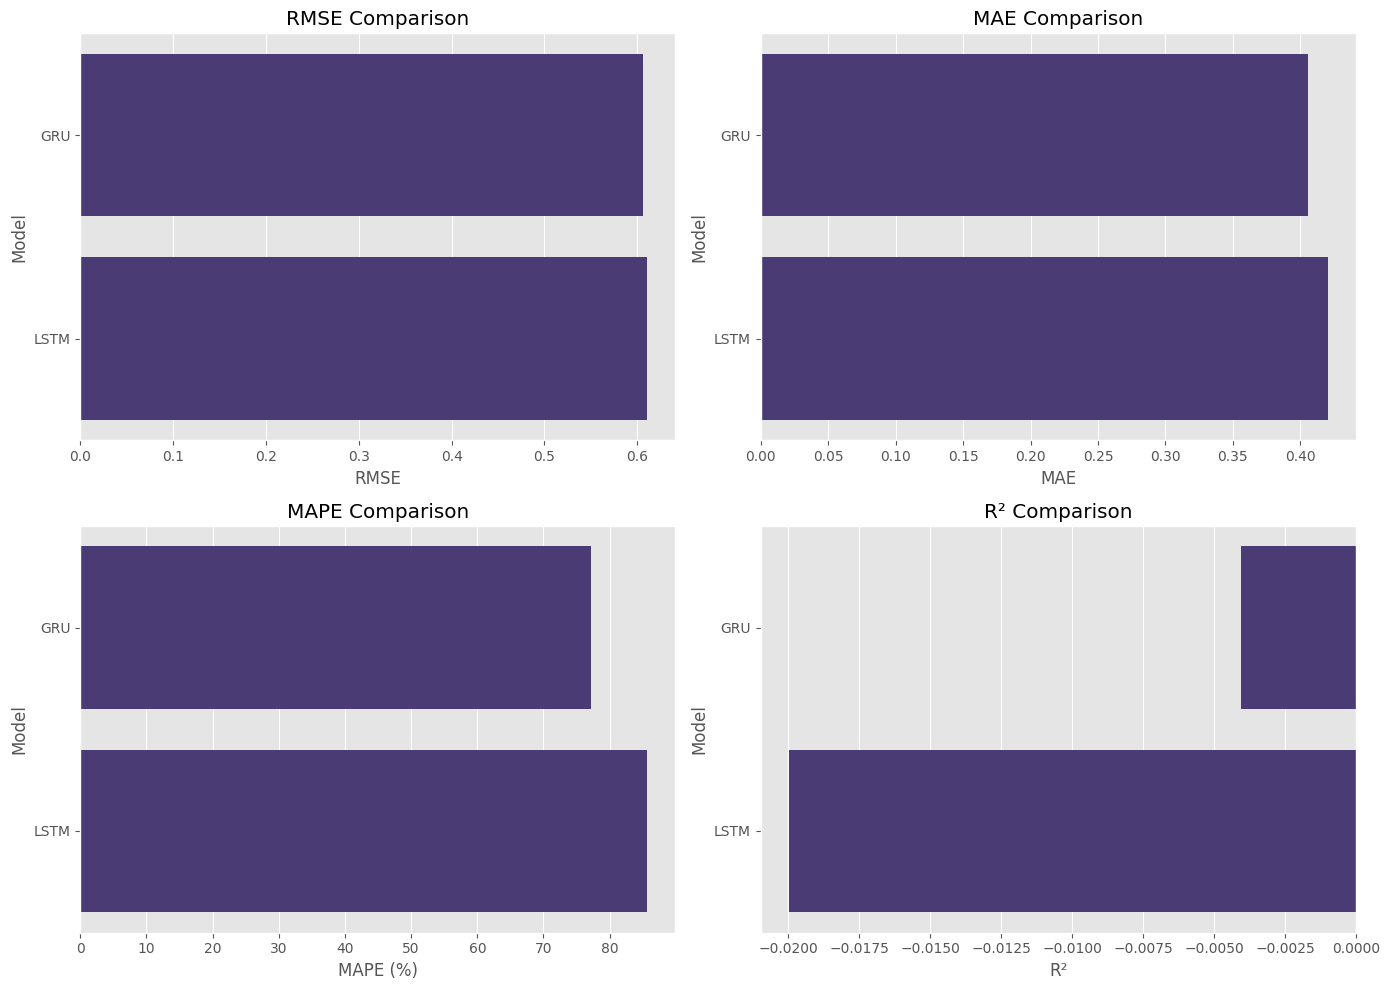

In [56]:
# Plot model comparison
# Plot comparison
plt.figure(figsize=(14, 10))

# RMSE comparison
plt.subplot(2, 2, 1)
sns.barplot(x='RMSE', y='Model', data=comparison)
plt.title('RMSE Comparison')

# MAE comparison
plt.subplot(2, 2, 2)
sns.barplot(x='MAE', y='Model', data=comparison)
plt.title('MAE Comparison')

# MAPE comparison
plt.subplot(2, 2, 3)
sns.barplot(x='MAPE (%)', y='Model', data=comparison)
plt.title('MAPE Comparison')

# R² comparison
plt.subplot(2, 2, 4)
sns.barplot(x='R²', y='Model', data=comparison)
plt.title('R² Comparison')

plt.tight_layout()
plt.show()

In [57]:
# Interpret results
# Find best model
best_model_idx = comparison['RMSE'].idxmin()
best_model = models_results[best_model_idx]

print(f"\nBest model: {best_model['name']} with RMSE of {best_model['rmse']:.4f}")

# Interpret RMSE in context of data
target_mean = stats.loc['Global_active_power', 'mean']
target_std = stats.loc['Global_active_power', 'std']
target_min = stats.loc['Global_active_power', 'min']
target_max = stats.loc['Global_active_power', 'max']

print(f"\nContext:")
print(f"- The average Global Active Power is {target_mean:.4f} kW")
print(f"- The standard deviation is {target_std:.4f} kW")
print(f"- The range is from {target_min:.4f} to {target_max:.4f} kW")

# Calculate normalized RMSE
nrmse = best_model['rmse'] / (target_max - target_min)
print(f"- The normalized RMSE is {nrmse:.4f} or {nrmse*100:.2f}% of the range")

# Calculate RMSE as percentage of mean
rmse_pct = best_model['rmse'] / target_mean * 100
print(f"- The RMSE is {rmse_pct:.2f}% of the mean value")


Best model: GRU with RMSE of 0.6059

Context:
- The average Global Active Power is 0.7464 kW
- The standard deviation is 0.7918 kW
- The range is from 0.0800 to 5.8060 kW
- The normalized RMSE is 0.1058 or 10.58% of the range
- The RMSE is 81.17% of the mean value


In [58]:
# Feature importance interpretation
# Interpret feature importance
print("\nKey insights from feature importance:")
top_features = importance.head(5)
for _, row in top_features.iterrows():
    print(f"- {row['Feature']} has a relative importance of {row['Importance']:.4f}")

# Provide overall interpretation
print("\nOverall interpretation:")
if best_model['r2'] > 0.9:
    quality = "excellent"
elif best_model['r2'] > 0.8:
    quality = "very good"
elif best_model['r2'] > 0.7:
    quality = "good"
elif best_model['r2'] > 0.6:
    quality = "moderate"
else:
    quality = "poor"

print(f"- The model provides {quality} predictions with {best_model['r2']*100:.1f}% of variance explained")
print(f"- On average, predictions are off by {best_model['mae']:.4f} kW (MAE)")
print(f"- The percentage error is {best_model['mape']:.2f}% (MAPE)")


Key insights from feature importance:
- power_voltage_ratio has a relative importance of 0.9084
- Global_intensity has a relative importance of 0.0826
- Global_active_power_diff_24 has a relative importance of 0.0023
- Global_active_power_rolling_std_6 has a relative importance of 0.0020
- Global_active_power_rolling_max_6 has a relative importance of 0.0019

Overall interpretation:
- The model provides poor predictions with -0.4% of variance explained
- On average, predictions are off by 0.4057 kW (MAE)
- The percentage error is 77.13% (MAPE)


In [1]:
# %% [Step 1: Enhanced Data Preparation] 
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load and preprocess data
df = pd.read_csv('data/power_consumption_data.csv', parse_dates=['datetime'], index_col='datetime')
df = df.sort_index()


print("Missing values before interpolation:")
print(df.isnull().sum())

# Handle missing values using temporal interpolation
df = df.interpolate(method='time').fillna(method='bfill')

print("Missing values after interpolation:")
print(df.isnull().sum())

# Create features
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month


Missing values before interpolation:
Global_active_power      15
Global_reactive_power    15
Voltage                  15
Global_intensity         15
Sub_metering_1           15
Sub_metering_2           15
Sub_metering_3           15
temp                      0
humidity                  0
conditions                0
dtype: int64
Missing values after interpolation:
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
temp                     0
humidity                 0
conditions               0
dtype: int64


C:\Users\bhusa\AppData\Local\Temp\ipykernel_17784\3483220478.py:15: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate(method='time').fillna(method='bfill')
C:\Users\bhusa\AppData\Local\Temp\ipykernel_17784\3483220478.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.interpolate(method='time').fillna(method='bfill')


In [2]:
# Encode weather conditions
conditions = df['conditions'].str.get_dummies(', ')
df = pd.concat([df, conditions], axis=1)


In [3]:
df

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,temp,humidity,conditions,day_of_week,month,Clear,Overcast,Partially cloudy,Rain,Snow
datetime,,,,,,,,,,,,,,,,,
2006-12-17,1.044,0.152,242.73,4.4,0.0,2.0,0.0,3.94,91.1,"Rain, Partially cloudy",6,12,0,0,1,1,0
2006-12-18,0.278,0.126,246.17,1.2,0.0,2.0,0.0,4.39,87.5,"Rain, Partially cloudy",0,12,0,0,1,1,0
2006-12-19,0.414,0.242,241.19,2.0,0.0,1.0,0.0,2.44,78.8,Partially cloudy,1,12,0,0,1,0,0
2006-12-20,0.824,0.058,245.57,3.4,0.0,0.0,0.0,2.72,72.3,Partially cloudy,2,12,0,0,1,0,0
2006-12-21,1.814,0.148,243.51,7.6,0.0,0.0,18.0,4.83,76.3,Partially cloudy,3,12,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-11-22,0.316,0.082,244.59,1.4,0.0,1.0,0.0,4.72,80.8,"Rain, Overcast",0,11,0,1,0,1,0
2010-11-23,0.402,0.178,242.36,1.8,0.0,2.0,0.0,4.89,79.4,"Rain, Partially cloudy",1,11,0,0,1,1,0
2010-11-24,0.334,0.080,242.06,1.4,0.0,2.0,0.0,5.39,80.1,"Rain, Partially cloudy",2,11,0,0,1,1,0


In [4]:
# Select key variables based on physical understanding of power systems
target = 'Global_active_power'
features = ['Sub_metering_1','Sub_metering_2','Sub_metering_3','temp', 'humidity',  'day_of_week', 'month',
            'Partially cloudy', 'Rain', 'Overcast', 'Clear','snow']

# Scientific Rationale:
# 1. Temporal interpolation preserves temporal patterns better than mean imputation
# 2. Cyclical encoding of time features (hour, day_of_week) helps models capture periodicity
# 3. Weather conditions directly impact power consumption (e.g., AC usage)
# 4. Temperature and humidity are key physical drivers of power demand

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[24] intercept   : AIC=3383.579, Time=4.86 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=4270.008, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=3885.865, Time=0.42 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=3380.388, Time=1.22 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=4268.008, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[24] intercept   : AIC=3383.124, Time=0.22 sec
 ARIMA(0,1,1)(1,0,1)[24] intercept   : AIC=3379.814, Time=2.68 sec
 ARIMA(0,1,1)(1,0,0)[24] intercept   : AIC=3380.755, Time=1.01 sec
 ARIMA(0,1,1)(2,0,1)[24] intercept   : AIC=3381.379, Time=12.55 sec
 ARIMA(0,1,1)(1,0,2)[24] intercept   : AIC=3382.110, Time=12.39 sec
 ARIMA(0,1,1)(0,0,2)[24] intercept   : AIC=3380.276, Time=5.68 sec
 ARIMA(0,1,1)(2,0,0)[24] intercept   : AIC=3380.743, Time=7.52 sec
 ARIMA(0,1,1)(2,0,2)[24] intercept   : AIC=3383.785, Time=13.78 sec
 ARIMA(0,1,0)(1,0,1)[24] intercept   : AIC=4269.821, Time=0.84 sec
 ARIMA(1,1,1)(1,

c:\Users\bhusa\OneDrive\Bijlagen\Desktop\EindProef_energy_forecast\energy_forecast\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\bhusa\OneDrive\Bijlagen\Desktop\EindProef_energy_forecast\energy_forecast\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\bhusa\OneDrive\Bijlagen\Desktop\EindProef_energy_forecast\energy_forecast\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


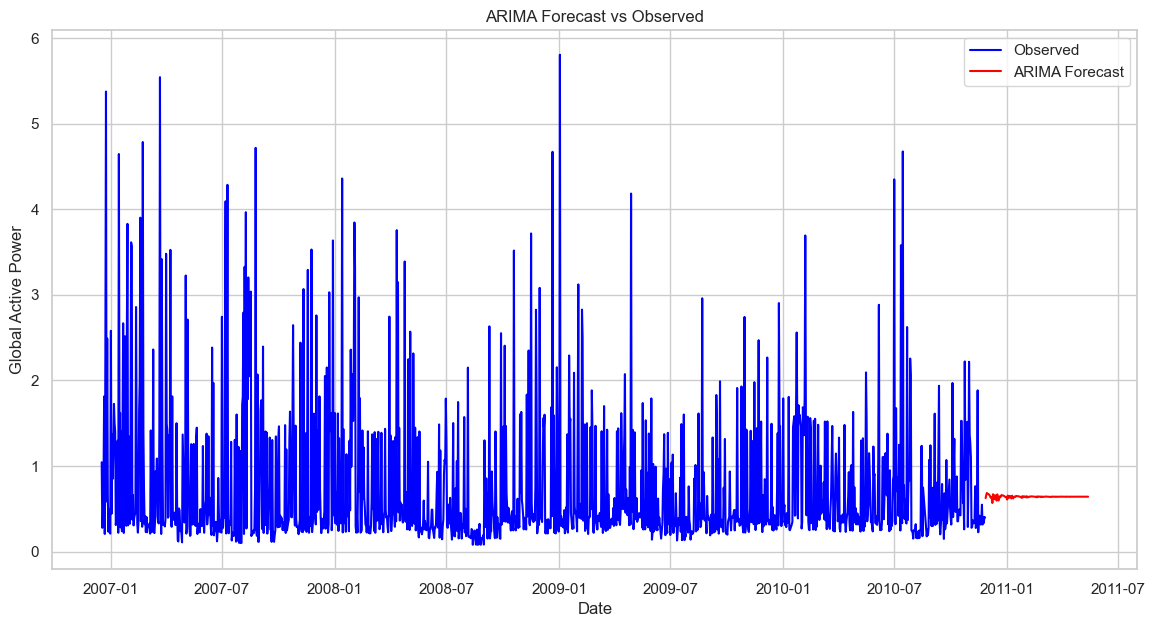

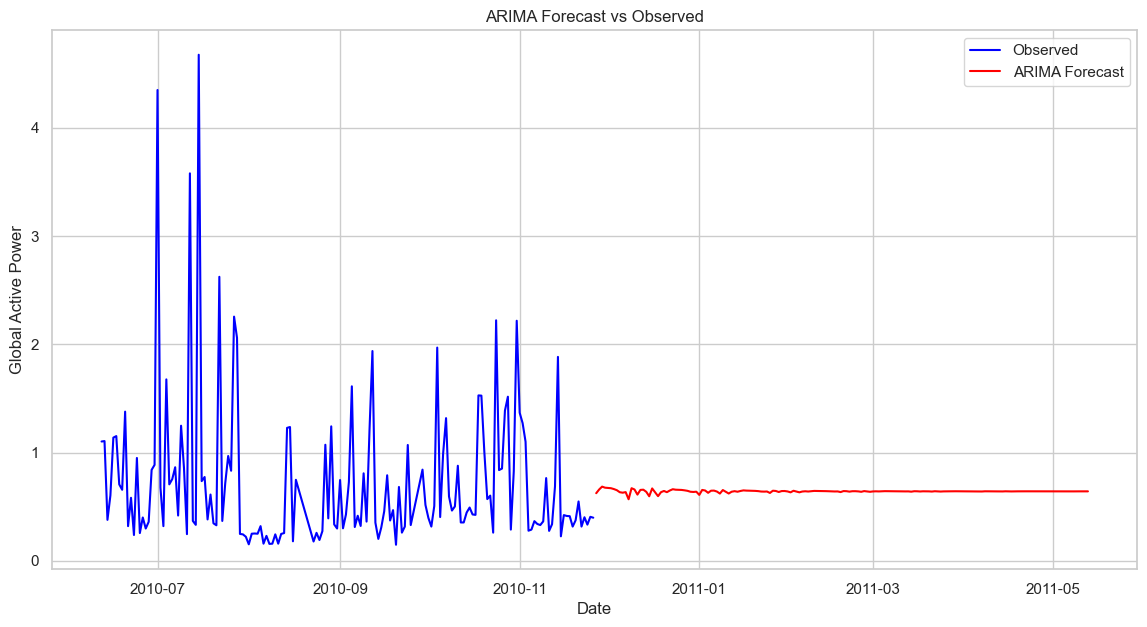

In [5]:
# %% [Step 2: ARIMA Modeling]
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

# Auto ARIMA for parameter selection
auto_model = auto_arima(df[target], seasonal=True, m=24,
                       suppress_warnings=True,
                       stepwise=True, trace=True)

# Fit best ARIMA model
arima_order = auto_model.order
seasonal_order = auto_model.seasonal_order

arima_model = ARIMA(df[target], order=arima_order, seasonal_order=seasonal_order)
arima_results = arima_model.fit()

# Forecast
arima_forecast = arima_results.get_forecast(steps=24*7).predicted_mean

# Scientific Interpretation:
# ARIMA (AutoRegressive Integrated Moving Average) models are linear models that:
# - Capture autocorrelation (AR)
# - Handle non-stationarity through differencing (I)
# - Model error structure (MA)
# Seasonal component (SARIMA) accounts for daily patterns (24h seasonality)
# Limitations: Assumes linear relationships and struggles with exogenous variables

# Visualize ARIMA forecast
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
plt.figure(figsize=(14, 7))
plt.plot(df[target], label='Observed', color='blue')
plt.plot(arima_forecast, label='ARIMA Forecast', color='red')
plt.title('ARIMA Forecast vs Observed')
plt.xlabel('Date')
plt.ylabel('Global Active Power')
plt.legend()
plt.show()

# visualize the loss
plt.figure(figsize=(14, 7))
plt.plot(df[target].iloc[-168:], label='Observed', color='blue')
plt.plot(arima_forecast, label='ARIMA Forecast', color='red')
plt.title('ARIMA Forecast vs Observed')
plt.xlabel('Date')
plt.ylabel('Global Active Power')
plt.legend()
plt.show()

